In [5]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 2. Load Dataset
df = pd.read_csv("data.csv", encoding='ISO-8859-1')
print("Shape:", df.shape)
df.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# 3. Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df.drop_duplicates(inplace=True)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Cleaned shape:", df.shape)


Cleaned shape: (392692, 9)


In [7]:
# 4. Feature Engineering - RFM
NOW = df['InvoiceDate'].max() + timedelta(days=1)
# 1. Create a new column for total purchase per row
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [9]:
# 5. Normalize the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


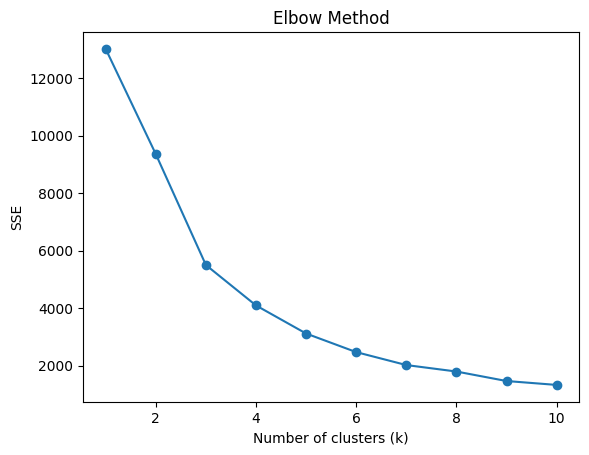

In [10]:
# 6. Elbow Method to find optimal K
sse = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    sse.append(model.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


In [11]:
# 7. Apply KMeans with chosen k (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


In [12]:
# 8. Analyze Clusters
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1353.625312
1,248.075914,1.552015,478.848773
2,7.384615,82.538462,127187.959231
3,15.500000,22.333333,12690.500392


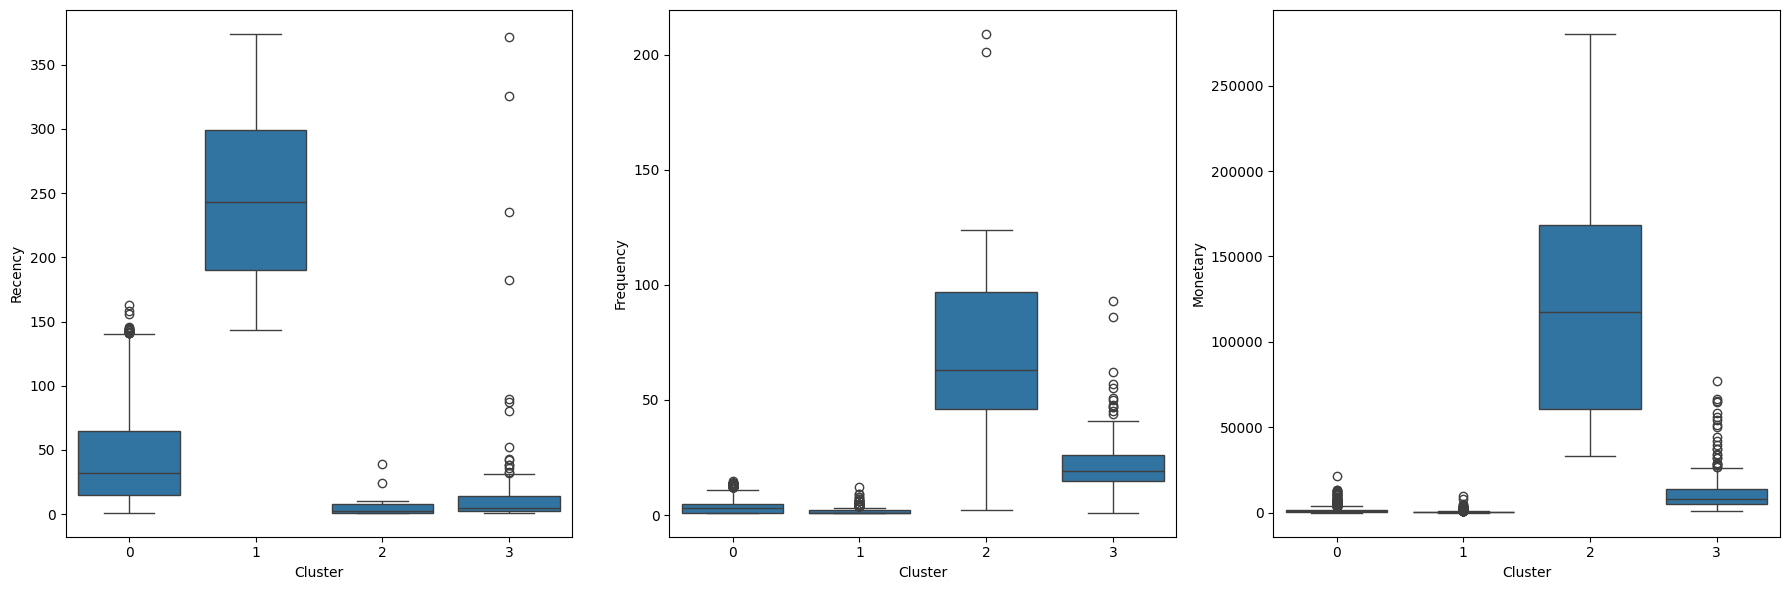

In [13]:
# 9. Visualize Clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0])
sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1])
sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2])
plt.tight_layout()
plt.show()


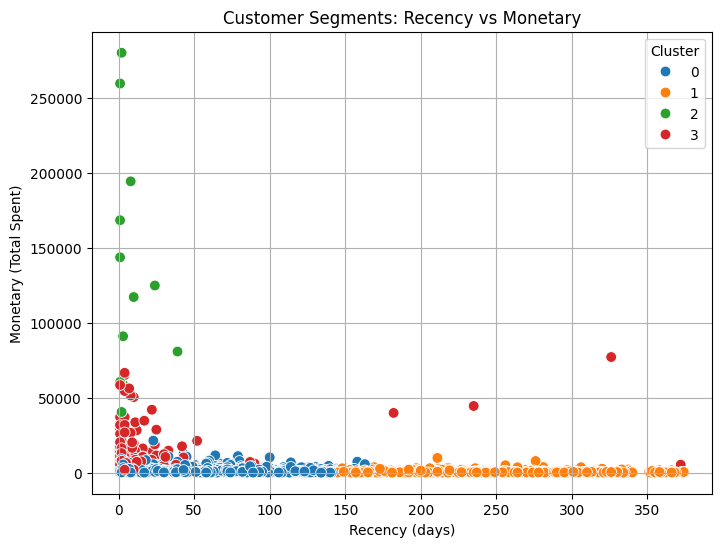

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10', s=60)
plt.title('Customer Segments: Recency vs Monetary')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (Total Spent)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


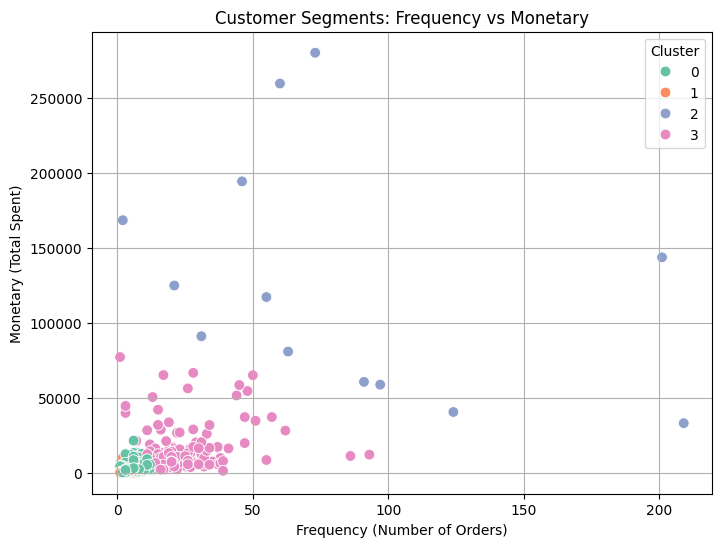

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', s=60)
plt.title('Customer Segments: Frequency vs Monetary')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Monetary (Total Spent)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


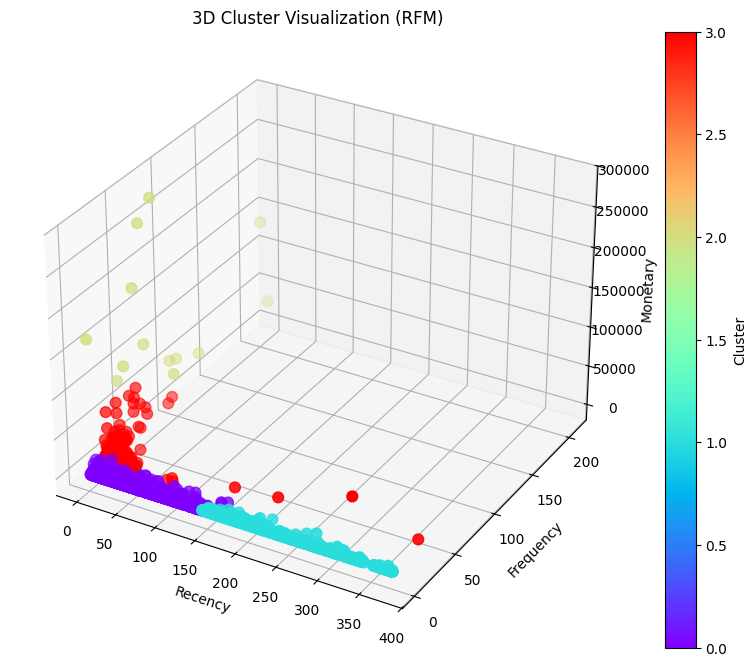

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm['Recency'],
    rfm['Frequency'],
    rfm['Monetary'],
    c=rfm['Cluster'],
    cmap='rainbow',
    s=60
)
ax.set_title('3D Cluster Visualization (RFM)')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.colorbar(scatter, label='Cluster')
plt.show()
